In [1]:
import geopandas as gpd
import pandas as pd

import mapillary as mly
#import json

import glob







### osm-netzwerk einlesen

In [2]:

#set_date = "250805" 
#set_date = "250930" 
set_date = "251010" 

cycleways=gpd.read_parquet(f"processed_osm_files/processed_cycleways_germany_{set_date}.parquet")
motorways=gpd.read_parquet(f"processed_osm_files/processed_motorways_germany_{set_date}.parquet")



In [3]:
len(cycleways)

7512947

In [4]:
len(motorways)

69695

In [5]:
cycleways.columns

Index(['osm_id', 'highway', 'bicycle', 'bicycle_forward', 'bicycle_backward',
       'cycleway', 'cycleway_left', 'cycleway_right', 'cycleway_both',
       'cycleway_lane', 'cycleway_track', 'cycleway_opposite',
       'cycleway_shared_lane', 'sidewalk_right_bicycle',
       'sidewalk_left_bicycle', 'sidewalk_both_bicycle', 'maxspeed',
       'maxspeed_conditional', 'maxspeed_backward', 'maxspeed_forward',
       'maxspeed_type', 'name', 'ref', 'surface', 'width', 'geometry'],
      dtype='object')

In [6]:
filtered_cycleways = cycleways[
    (cycleways["bicycle"].isin(["designated"])) |
    (cycleways["bicycle_backward"].isin(["designated"])) |
    (cycleways["bicycle_forward"].isin(["designated"])) |
    (cycleways["highway"].isin(["cycleway"])) |
    (cycleways["cycleway"].notnull() & (cycleways["cycleway"] != "no")) |
    (cycleways["cycleway_left"].notnull() & (cycleways["cycleway_left"] != "no")) |
    (cycleways["cycleway_right"].notnull() & (cycleways["cycleway_right"] != "no")) |
    (cycleways["cycleway_both"].notnull() & (cycleways["cycleway_both"] != "no")) |
    (cycleways["cycleway_lane"].notnull() & (cycleways["cycleway_lane"] != "no")) |
    (cycleways["cycleway_track"].notnull() & (cycleways["cycleway_track"] != "no")) |
    # (cycleways["sidewalk"].isin(["designated"])) |  TODO: add "sidewalk" in ini file
    (cycleways["sidewalk_right_bicycle"].isin(["designated"])) |
    (cycleways["sidewalk_left_bicycle"].isin(["designated"])) |
    (cycleways["sidewalk_both_bicycle"].isin(["designated"])) 
]
len(filtered_cycleways)

762438

<Axes: >

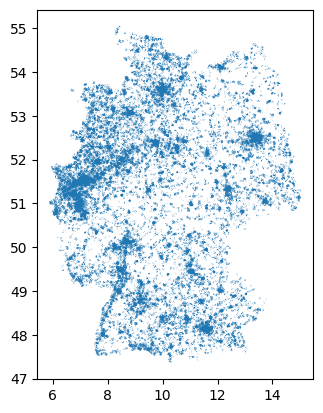

In [7]:
filtered_cycleways[::10].plot()

<Axes: >

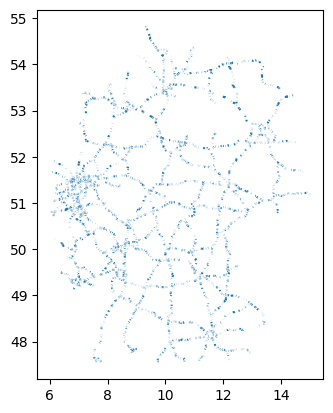

In [17]:
motorways[::10].plot()

In [19]:
filtered_cycleways_proj = filtered_cycleways.to_crs(25833)
filtered_cycleways_proj["length_m"] = filtered_cycleways_proj.geometry.length
#filtered_cycleways_proj[["osm_id", "length_m"]]

total_km = filtered_cycleways_proj.length_m.sum() / 1000
print(f"Gesamtlänge der gefilterten 'Radwege': {total_km:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".") + " km")

Gesamtlänge der gefilterten 'Radwege': 137.651,57 km


In [18]:
#filtered_cycleways.highway.value_counts()

### mapillary traffic signs einlesen

In [ ]:


## TRAFFFIC SIGNS
# https://www.mapillary.com/developer/api-documentation/traffic-signs?locale=

# Unterschiedliche Verkehrszeichen in Deutschland für Radwege

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:237
# Radweg
de_237="regulatory--bicycles-only--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:240
# Gemeinsamer Geh- und Radweg
de_240="regulatory--shared-path-pedestrians-and-bicycles--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:241-30
# Getrennter Rad- und Gehweg
de_241_30="regulatory--dual-path-bicycles-and-pedestrians--g1"

# https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:241-31
# Getrennter Rad- und Gehweg
de_241_31="regulatory--dual-path-pedestrians-and-bicycles--g1"


# ggf. noch  "complementary--except-bicycles--g1" https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:1022-10



# 2025-06-07 ## -> 184120 features
# 2025-07-30 ## -> 213732 features
# 2025-08-05 ## -> 214438 features
# 2025-09-08 ## -> 220510 features


# Find all parquet files in the tile_cache folder (per state)
parquet_files = glob.glob("../../output/*.parquet")
# Extract and print the dates from the filenames
dates = [f.split("_")[-1].replace(".parquet", "") for f in parquet_files]
# Drop all duplicates in the list
dates = list(set(dates))
print("Dates found in filenames:", dates)
# Read all files and concatenate into one GeoDataFrame
mapillary_trafficsigns = gpd.GeoDataFrame(
    pd.concat([gpd.read_parquet(f) for f in parquet_files], ignore_index=True),
    crs=gpd.read_parquet(parquet_files[0]).crs
)



# filter to cw only
mapillary_trafficsigns_cw=mapillary_trafficsigns[mapillary_trafficsigns.value.isin([de_237, de_240, de_241_30, de_241_31])]
# drop duplicates if any
mapillary_trafficsigns_cw=mapillary_trafficsigns_cw.drop_duplicates(subset=['id'])

mapillary_trafficsigns_cw




Dates found in filenames: ['2025-10-11']


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
2,POINT (8.29728 54.87519),2016-09-06,1820694428091863,2016-09-06,regulatory--shared-path-pedestrians-and-bicycl...,8569,5192
34,POINT (8.29949 54.89374),2016-09-06,533889454272406,2016-09-06,regulatory--bicycles-only--g1,8569,5190
40,POINT (8.29982 54.88667),2025-06-27,1098704175663599,2025-06-27,regulatory--shared-path-pedestrians-and-bicycl...,8569,5191
44,POINT (8.29988 54.88679),2025-06-27,2217948735386355,2025-06-27,regulatory--shared-path-pedestrians-and-bicycl...,8569,5191
47,POINT (8.29638 54.88012),2016-09-07,500400877822586,2016-09-07,regulatory--shared-path-pedestrians-and-bicycl...,8569,5191
...,...,...,...,...,...,...,...
6297807,POINT (8.96308 53.05755),2018-03-18,251362246774370,2018-03-18,regulatory--dual-path-bicycles-and-pedestrians...,8599,5332
6297829,POINT (8.964 53.05729),2025-08-16,1462451174804015,2025-08-16,regulatory--dual-path-pedestrians-and-bicycles...,8599,5332
6297834,POINT (8.96359 53.05766),2025-08-16,3058286184362909,2025-08-16,regulatory--dual-path-bicycles-and-pedestrians...,8599,5332
6297838,POINT (8.96407 53.0572),2017-04-17,129610735792136,2022-04-11,regulatory--dual-path-bicycles-and-pedestrians...,8599,5332


In [22]:
from datetime import datetime


# Save cw traffic sings to compressed GeoJSON and update readme

with gzip.open("ts_output/mapillary_trafficsigns_cw-237-240-241_latest.geojson.gz", "wt", encoding="utf-8") as f:
    f.write(mapillary_trafficsigns_cw.to_json())

    # Get the current date
    current_date = datetime.now().strftime("%Y-%m-%d")

    # Create the content for the README file
    readme_content = f"""
# Traffic Signs Output
This folder contains the output files for traffic signs analysis.  
The output has been created on {current_date}.
    """

    # Write the README file
    with open("ts_output/README.md", "w", encoding="utf-8") as readme_file:
        readme_file.write(readme_content)

# Save cw traffic sings to geoparquet
#mapillary_trafficsigns_cw.to_parquet("mapillary_trafficsigns_cw-237-240-241.parquet")

In [ ]:
##  newer than 2025-01-01  

# september 2025: 36488
# oktober   2025: 41263


mapillary_trafficsigns_cw=mapillary_trafficsigns_cw[mapillary_trafficsigns_cw["last_seen_at"] > "2025-01-01"]
# mapillary_trafficsigns_237_recent
len(mapillary_trafficsigns_cw)

41263

In [14]:
from datetime import datetime

##  at least 12 months between first and last seen (to avoid temporary signs)
## might need to adjust this

def months_between(date1, date2):
    d1 = datetime.strptime(date1, "%Y-%m-%d")
    d2 = datetime.strptime(date2, "%Y-%m-%d")
    return abs((d2.year - d1.year) * 12 + d2.month - d1.month)

mapillary_trafficsigns_cw_temp = mapillary_trafficsigns_cw[
    mapillary_trafficsigns_cw.apply(lambda row: months_between(row['first_seen_at'], row['last_seen_at']) >= 12, axis=1)
]
mapillary_trafficsigns_cw_temp

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
425,POINT (8.31794 54.92832),2022-07-24,603163378052143,2025-06-28,regulatory--shared-path-pedestrians-and-bicycl...,8570,5187
1371,POINT (8.33455 54.94578),2022-07-24,652670826292310,2025-06-28,regulatory--shared-path-pedestrians-and-bicycl...,8571,5186
1380,POINT (8.33661 54.95007),2016-09-05,500756644409506,2025-06-28,regulatory--shared-path-pedestrians-and-bicycl...,8571,5186
1447,POINT (8.33522 54.96407),2016-09-10,300156345014290,2025-06-28,regulatory--shared-path-pedestrians-and-bicycl...,8571,5185
1463,POINT (8.33858 54.95697),2016-09-05,1143774722763600,2025-06-28,regulatory--shared-path-pedestrians-and-bicycl...,8571,5185
...,...,...,...,...,...,...,...
6295891,POINT (8.89305 53.08232),2017-05-07,1797425837083672,2025-05-30,regulatory--bicycles-only--g1,8596,5330
6297195,POINT (8.90187 53.07518),2019-04-06,466999907722714,2025-05-16,regulatory--bicycles-only--g1,8597,5331
6297214,POINT (8.90197 53.07449),2019-04-06,941892403273211,2025-05-16,regulatory--bicycles-only--g1,8597,5331
6297263,POINT (8.90211 53.07263),2019-04-06,941758539953264,2025-05-16,regulatory--bicycles-only--g1,8597,5331


<Axes: >

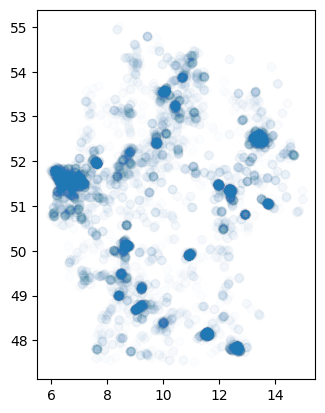

In [15]:
mapillary_trafficsigns_cw_temp.plot(alpha=0.01)

In [16]:
## now create a buffer around the traffic signs to check if there is a cycleway nearby
df_buffered = mapillary_trafficsigns_cw_temp.to_crs(25833).copy()
#df_buffered["geometry"] = df_buffered.geometry.buffer(50)
#df_buffered["geometry"] = df_buffered.geometry.buffer(40)
df_buffered["geometry"] = df_buffered.geometry.buffer(30)
df_buffered = df_buffered.to_crs(mapillary_trafficsigns_cw_temp.crs)


In [ ]:

def mark_intersections(buffered_df, target_layer, column_name="has_intersection"):
    """
    Marks which geometries in `buffered_df` intersect with `target_layer`.

    Parameters:
    - buffered_df (GeoDataFrame): The GeoDataFrame containing buffered geometries.
    - target_layer (GeoDataFrame): The GeoDataFrame to check for intersections (e.g., cycleways, motorways).
    - column_name (str): Name of the column to add/overwrite in `buffered_df` indicating intersection (bool).

    Returns:
    - GeoDataFrame: `buffered_df` with a new boolean column `column_name`.
    """
    # Ensure CRS matches
    buffered_df = buffered_df.to_crs(target_layer.crs)

    # Perform spatial join to find intersecting geometries
    joined = gpd.sjoin(buffered_df, target_layer, how="inner", predicate="intersects")

    # Initialize the new column to False
    buffered_df[column_name] = False

    # Set True for geometries that intersect
    matches = joined.index.unique()
    buffered_df.loc[matches, column_name] = True

    return buffered_df


In [18]:
# For cycleways
df_buffered = mark_intersections(df_buffered, filtered_cycleways, column_name="has_cw_intersection")

# For motorways
df_buffered = mark_intersections(df_buffered, motorways, column_name="has_mw_intersection")


In [19]:


# Step 2: Ensure CRS matches
df_buffered = df_buffered.to_crs(filtered_cycleways.crs)

# Step 3: Perform spatial join (find intersecting geometries)
joined = gpd.sjoin(df_buffered, filtered_cycleways, how="inner", predicate="intersects")

# # Step 4: Mark which polygons had at least one intersection
# df_6months_30_buffered["has_30_intersection"] = df_6months_30_buffered.index.isin(joined.index)

# Zeilen, die mindestens einen Match haben
matches = joined.index.unique()

# Standardmäßig alles auf False setzen
df_buffered["has_cw_intersection"] = False

# Nur die gematchten Indizes auf True setzen
df_buffered.loc[matches, "has_cw_intersection"] = True



In [20]:
#df_buffered.id.unique()

In [21]:
df_buffered.has_cw_intersection.value_counts()

has_cw_intersection
True     15248
False      189
Name: count, dtype: int64

In [22]:
df_buffered.has_mw_intersection.value_counts()

has_mw_intersection
False    15324
True       113
Name: count, dtype: int64

In [23]:
df_buffered_false=df_buffered[(df_buffered.has_cw_intersection== False) & (df_buffered.has_mw_intersection== False)].copy()

In [24]:
len(df_buffered_false)

133

In [25]:
# df_buffered_false.explore(
#     color="red",
#     tiles="CartoDB positron",
#     popup=True,
#     tooltip=["value", "first_seen_at", "last_seen_at"]
# )

In [26]:
df_buffered_false


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection
11663,"POLYGON ((9.04334 54.47712, 9.04334 54.47709, ...",2015-05-14,219866072894437,2025-06-27,regulatory--dual-path-pedestrians-and-bicycles...,8603,5223,False,False
14897,"POLYGON ((9.08491 54.19483, 9.08491 54.19481, ...",2016-08-05,319070272909785,2025-07-20,regulatory--dual-path-bicycles-and-pedestrians...,8605,5245,False,False
104867,"POLYGON ((10.58858 53.37512, 10.58858 53.3751,...",2018-08-01,1133660103806072,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8673,5308,False,False
105108,"POLYGON ((10.58871 53.3751, 10.58871 53.37507,...",2023-06-28,2207770119408621,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8673,5308,False,False
106080,"POLYGON ((10.59874 53.9407, 10.59874 53.94067,...",2023-08-10,157340140724136,2025-10-01,regulatory--shared-path-pedestrians-and-bicycl...,8674,5265,False,False
...,...,...,...,...,...,...,...,...,...
6092918,"POLYGON ((9.33038 48.80523, 9.33038 48.80521, ...",2023-03-02,3402062016712875,2025-04-08,regulatory--shared-path-pedestrians-and-bicycl...,8616,5640,False,False
6098780,"POLYGON ((9.32277 47.72535, 9.32277 47.72532, ...",2020-01-10,778543676382616,2025-07-04,regulatory--shared-path-pedestrians-and-bicycl...,8616,5713,False,False
6158434,"POLYGON ((9.54721 48.52289, 9.54721 48.52287, ...",2024-10-11,1340089623883360,2025-10-02,regulatory--shared-path-pedestrians-and-bicycl...,8626,5659,False,False
6217193,"POLYGON ((9.85886 47.68037, 9.85886 47.68034, ...",2018-06-07,306727251036897,2025-09-04,regulatory--bicycles-only--g1,8640,5716,False,False


In [27]:
### import the the flagged (not created, fixed) tasks from the challenge. 

challenge_gdf = gpd.read_file("challenge_52916_data_f_mr.geojson")
challenge_gdf.head()

,osmid,mr_tags,image_id,mr_mapper,mr_taskId,instruction,mr_mappedOn,mr_reviewer,mr_taskName,mr_responses,mr_reviewedAt,mr_taskStatus,Verkehrzeichen,mr_challengeId,mr_reviewStatus,mr_taskPriority,mr_reviewTimeSeconds,geometry
0,115861484250257,None,1262259444239530,None,306587608,\n### 🚧 Aufgabe: Verkehrszeichen **DE:237** ...,2025-10-01 08:39:58+00:00,None,115861484250257,None,None,Not_An_Issue,237,52916,None,High,None,POINT (13.39547 52.53266)
1,1347392769213873,None,987952138939492,None,306203478,\n### 🚧 Aufgabe: Verkehrszeichen **DE:240** ...,2025-09-27 11:41:20+00:00,None,1347392769213873,None,None,Not_An_Issue,240,52916,None,High,None,POINT (7.36834 50.97668)
2,977477283090053,None,776249919711409,None,306203485,\n### 🚧 Aufgabe: Verkehrszeichen **DE:240** ...,2025-09-25 07:30:09+00:00,None,977477283090053,None,None,Not_An_Issue,240,52916,None,High,None,POINT (8.4865 49.92966)
3,115798103961261,None,492906455340355,None,306203494,\n### 🚧 Aufgabe: Verkehrszeichen **DE:240** ...,2025-09-23 07:51:11+00:00,None,115798103961261,None,None,Not_An_Issue,240,52916,None,High,None,POINT (13.43241 52.61395)
4,1390704384825415,None,1438918813532601,None,306203493,\n### 🚧 Aufgabe: Verkehrszeichen **DE:240** ...,2025-09-23 07:51:08+00:00,None,1390704384825415,None,None,Not_An_Issue,240,52916,None,High,None,POINT (13.43214 52.61435)


In [28]:
df_buffered_false.crs

<Geographic 2D CRS: OGC:CRS84>
Name: WGS 84 (CRS84)
Axis Info [ellipsoidal]:
- Lon[east]: Geodetic longitude (degree)
- Lat[north]: Geodetic latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [29]:
df_buffered_false = df_buffered_false.to_crs(4326)

In [30]:
# Find intersections
intersections = gpd.sjoin(df_buffered_false, challenge_gdf, how="left", predicate="intersects")

# Keep only rows that do NOT intersect (i.e., no match in challenge_gdf)
df_buffered_false_no_challenge = df_buffered_false.loc[intersections.index[intersections["index_right"].isna()]] 

In [31]:
len(df_buffered_false_no_challenge)

105

In [32]:
## retrieve the image ID for the map features

In [33]:
#df_process_img= df_buffered_false.copy()
df_process_img= df_buffered_false_no_challenge.copy()

In [34]:
import sys
import os
import json
import logging
from contextlib import contextmanager
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# -- suppress stdout context manager --
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# -- Load config & set Mapillary token --
with open("config_mapillary_privat.json", "r") as f:
    config = json.load(f)

access_token = config["ACCESS_TOKEN"]
mly.interface.set_access_token(access_token)

# -- Logging cleanup --
for name in logging.root.manager.loggerDict:
    logging.getLogger(name).setLevel(logging.WARNING)
logging.basicConfig(level=logging.ERROR)

# -- Your image fetching function --
def get_image_id(map_feature_id):
    try:
        feature_str = mly.interface.feature_from_key(key=str(map_feature_id))
        feature = json.loads(feature_str)
        images = feature["features"]["properties"]["images"]["data"]
        return images[-1]["id"] if images else None
    except Exception as e:
        return None  # Or log the error if needed

# -- Parallelized version using ThreadPoolExecutor --
def parallel_get_image_ids(ids, max_workers=8):
    results = [None] * len(ids)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(get_image_id, id_): idx for idx, id_ in enumerate(ids)}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching image IDs"):
            idx = futures[future]
            try:
                results[idx] = future.result()
            except Exception:
                results[idx] = None  # Or log
    return results

# -- Apply to your dataframe --
with suppress_stdout():
    df_process_img["image_id"] = parallel_get_image_ids(df_process_img["id"].tolist(), max_workers=5)  # Adjust max_workers as needed, 5 is fastest for me


Fetching image IDs: 100%|██████████| 105/105 [00:19<00:00,  5.50it/s]


In [35]:
df_process_img.head()

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,image_id
11663,"POLYGON ((9.04334 54.47712, 9.04334 54.47709, ...",2015-05-14,219866072894437,2025-06-27,regulatory--dual-path-pedestrians-and-bicycles...,8603,5223,False,False,215122343377982
14897,"POLYGON ((9.08491 54.19483, 9.08491 54.19481, ...",2016-08-05,319070272909785,2025-07-20,regulatory--dual-path-bicycles-and-pedestrians...,8605,5245,False,False,4281036725273642
104867,"POLYGON ((10.58858 53.37512, 10.58858 53.3751,...",2018-08-01,1133660103806072,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8673,5308,False,False,517416299622543
105108,"POLYGON ((10.58871 53.3751, 10.58871 53.37507,...",2023-06-28,2207770119408621,2025-08-16,regulatory--shared-path-pedestrians-and-bicycl...,8673,5308,False,False,934812767805264
106080,"POLYGON ((10.59874 53.9407, 10.59874 53.94067,...",2023-08-10,157340140724136,2025-10-01,regulatory--shared-path-pedestrians-and-bicycl...,8674,5265,False,False,1027546151735874


In [36]:
centroids = df_process_img.copy()
centroids=centroids.to_crs(25832)
centroids["geometry"] = centroids.geometry.centroid
centroids=centroids.to_crs(4326)

centroids.sort_values("last_seen_at")


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,has_cw_intersection,has_mw_intersection,image_id
5328377,POINT (8.33813 51.6686),2024-02-25,394575303453637,2025-02-15,regulatory--bicycles-only--g1,8571,5436,False,False,336205985741566
3471569,POINT (9.98299 53.54787),2023-04-06,6466767800002742,2025-02-20,regulatory--bicycles-only--g1,8646,5295,False,False,173073772266521
6265114,POINT (10.10936 48.95079),2023-03-15,2849317388538058,2025-02-25,regulatory--shared-path-pedestrians-and-bicycl...,8652,5630,False,False,2469130539918647
2419735,POINT (10.37756 50.27216),2023-10-29,1056873315670680,2025-02-28,regulatory--shared-path-pedestrians-and-bicycl...,8664,5537,False,False,1846113672550404
4316498,POINT (6.1166 51.69266),2022-05-26,2773393686301190,2025-03-02,regulatory--shared-path-pedestrians-and-bicycl...,8470,5434,False,False,2176524992515812
...,...,...,...,...,...,...,...,...,...,...
2115011,POINT (13.43395 52.87541),2024-10-21,1071412457919795,2025-10-03,regulatory--shared-path-pedestrians-and-bicycl...,8803,5346,False,False,546866737965879
1403185,POINT (11.46184 51.75294),2023-10-28,716787189804960,2025-10-04,regulatory--dual-path-bicycles-and-pedestrians...,8713,5430,False,False,866000135248381
1403148,POINT (11.45774 51.74496),2020-01-08,2972654106283570,2025-10-04,regulatory--shared-path-pedestrians-and-bicycl...,8713,5430,False,False,151361963629669
1403115,POINT (11.45817 51.74528),2020-01-08,463361614768378,2025-10-04,regulatory--shared-path-pedestrians-and-bicycl...,8713,5430,False,False,216798549977025


In [37]:
# Mapping dictionary
value_to_vz = {
    'regulatory--dual-path-pedestrians-and-bicycles--g1': 241,
    'regulatory--dual-path-bicycles-and-pedestrians--g1': 241,
    'regulatory--bicycles-only--g1': 237,
    'regulatory--shared-path-pedestrians-and-bicycles--g1': 240
}

# Add new column based on mapping
centroids["VZ"] = centroids["value"].map(value_to_vz)

In [38]:
#centroids

In [39]:
import uuid

def to_maproulette_geojson_with_links(gdf, id_field="id", name_field="value", image_field="image_id"):
    features = []

    for _, row in gdf.iterrows():
        geom = row.geometry
        centroid = geom.centroid
        lat, lon = round(centroid.y, 6), round(centroid.x, 6)

        # Optional: Mapillary image
        image_url = None
        image_id = None
        if pd.notna(row.get(image_field)):
            image_id = str(int(row[image_field]))
            image_url = (
                f"https://www.mapillary.com/app/?pKey={image_id}"
                "&focus=photo"
                "&trafficSign[]=regulatory--bicycles-only--g1"
                "&trafficSign[]=regulatory--shared-path-pedestrians-and-bicycles--g1"
                "&trafficSign[]=regulatory--dual-path-bicycles-and-pedestrians--g1"
                "&trafficSign[]=regulatory--dual-path-pedestrians-and-bicycles--g1"
            )

        # TILDA link
        tilda_url = f"https://tilda-geo.de/regionen/radinfra?map=17.4/{lat}/{lon}&config=pdqyyt.7h3d.16g9vk&v=2"

#         # Build instruction
        instruction = f"""  
### 🚧 Aufgabe: Verkehrszeichen **DE:{row["VZ"]}** überprüfen und Radinfra hinzufügen
Bitte schaue dir den Bereich rund um dieses erkannte Verkehrszeichen an. Vermutlich fehlt hier eine Radinfrastruktur, die du hinzufügen kannst.

---

### 🖼️ Bild & Karte

- 📷 [**Mapillary-Bild anzeigen**]({image_url})  
(Hinweis: Das zuerst angezeigte Bild ist wahrscheinlich nicht das neueste – die neueste Aufnahme hier ist von **{row["last_seen_at"]})**

- 🗺️ [**In radinfra.de bzw TILDA ansehen**]({tilda_url})  
(Hinweis: Ist hilfreich um den aktuellen Stand der Radinfrastruktur vor Ort zu prüfen.)

---

### 📚 Nützliche Links

- 🛑 [**Traffic Sign Tool** – DE:{row["VZ"]}](https://trafficsigns.osm-verkehrswende.org/DE?signs=DE:{row["VZ"]})  
- 🚴 [**OSM-Wiki: Radverkehrsanlagen kartieren**](https://wiki.openstreetmap.org/wiki/DE:Bicycle/Radverkehrsanlagen_kartieren)

---

Viel Erfolg beim Prüfen und Mappen! 🗺️
        """

        # Build properties
        props = {
            #"identifier": str(row[id_field]),
            "image_id": str(row[id_field]),
            "Verkehrzeichen": str(row["VZ"]),
            "instruction": instruction#.strip()
        }

        # Build feature
        feature = {
            "type": "Feature",
            "geometry": row["geometry"].__geo_interface__,
            "properties": props,
            # Set the top-level ID here
            "id": image_id
        }

        # # Add Mapillary attachment if available
        # if image_id:
        #     feature["attachments"] = [
        #         {
        #             "id": str(uuid.uuid4()),
        #             "kind": "referencePhoto",
        #             "type": "mapillary",
        #             "format": "image",
        #             "data": image_id
        #         }
        #     ]

        features.append(feature)

    return {
        "type": "FeatureCollection",
        "features": features
    }


In [40]:
# Convert your df_buffered_false (or any GeoDataFrame) to GeoJSON
maproulette_geojson = to_maproulette_geojson_with_links(centroids)

# Save to file
with open("maproulette_tasks_missing-cw_instruction_vz_name_new.geojson", "w") as f:
    json.dump(maproulette_geojson, f, indent=2)


In [ ]:
### Maproulette stuff....

In [ ]:
## Add missing cycleways based on mapillary signs (Germany)


## 🚲 Fehlende Radwege anhand von Mapillary-Verkehrszeichen ergänzen (Deutschland)

Diese Challenge basiert auf automatisch erkannten, radverkehrsbezogenen Verkehrszeichen aus Mapillary-Bildern in Deutschland.

### 📌 Kriterien für jede Aufgabe

Nur Aufgaben, die **alle** folgenden Bedingungen erfüllen, wurden berücksichtigt:

- Das Verkehrszeichen wurde **in Mapillary erkannt**.
- Es handelt sich um ein **radverkehrsbezogenes Zeichen**  
  *(z. B. gemeinsamer Geh- und Radweg, reiner Radweg, getrennter Geh-/Radweg)*.
- Das Zeichen wurde **mindestens 12 Monate lang regelmäßig gesehen**.
- Die neuste Aufnahme stammt **aus dem Jahr 2025**.
- Es existiert **kein OSM-"Radweg" innerhalb von 50 m** des Standortes.

---

### 🔍 Was du tun solltest

1. Öffne den Ort in **Mapillary** und **radinfra.de** sowie einem Editor.
2. Prüfe, ob an der Stelle eine **Radinfrastruktur fehlt**.
3. Falls ja, ergänze die passenden OSM-Tags:  
   z. B. `highway=cycleway`, `cycleway=*`, `bicycle=designated`, etc.
4. Wenn bereits alles korrekt gemappt ist, kannst du die Aufgabe einfach **als erledigt markieren**.

---

🗺️ Vielen Dank für deine Hilfe beim Ausbau der Radinfrastruktur in OSM!

In [ ]:
'''
{{instruction}}
                                                                                             .
'''